# Food Recognition model using PyTorch using Food101 dataset

* author: Amal Varghese
* email: officialamalv2004@gmail.com

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets

print("Using PyTorch version:", torch.__version__)
print("Using torchvision version:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Using PyTorch version: 2.7.0+cu118
Using torchvision version: 0.22.0+cu118
Device: cuda


# Getting the data ready
- using torchvision datasets
- apply a custom transform

In [2]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    # transforms.Normalize(                     # Normalize to ImageNet mean/std
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.ToTensor(),
    # transforms.Normalize(                     # Normalize to ImageNet mean/std
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

print(f"Train transform: {train_transform}")
print(f"Test transform: {test_transform}")

Train transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)
Test transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [3]:
train_data = datasets.Food101(
    root="data",
    split="train",
    download=False,
    transform=train_transform,
)

test_data = datasets.Food101(
    root="data",
    split="test",
    download=False,
    transform=test_transform
)

print(f"Length of train_dataset: {len(train_data)}")
print(f"length of test data: {len(test_data)}")

Length of train_dataset: 75750
length of test data: 25250


# Exploartory Data Analysis

In [4]:
test_data_refined = torch.utils.data.Subset(test_data, range(0, 10000))
print(f"length of new test data: {len(test_data_refined)}")

length of new test data: 10000


In [5]:
image, label = train_data[0]
print(f"Image Shape: {image.shape} -> [color channels , height, width]")
classes = train_data.classes
print(f"Total number of classes:{len(classes)}")

Image Shape: torch.Size([3, 224, 224]) -> [color channels , height, width]
Total number of classes:101


In [6]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up from notebooks/ to project root


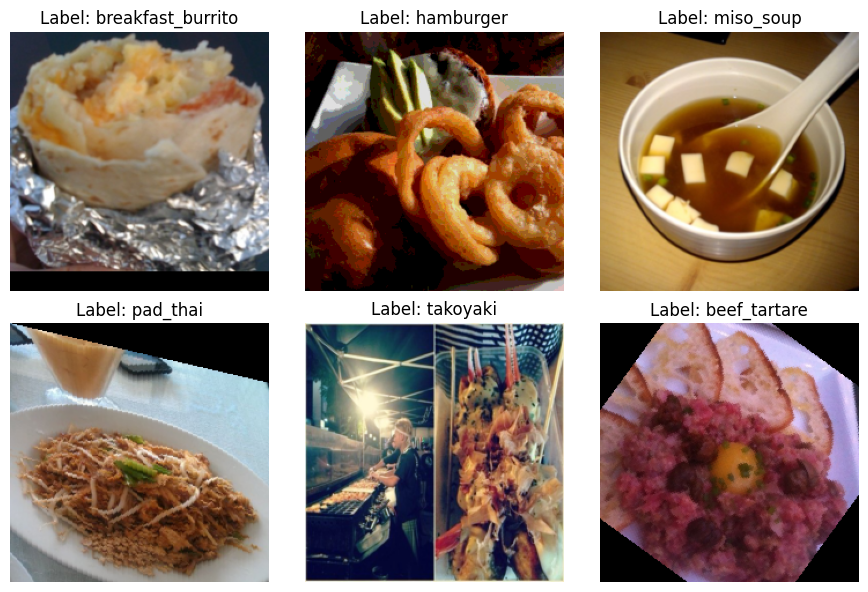

In [7]:
from helper.Visualize import plot_random_images
from helper.Visualize import plot_image

plot_random_images(train_data , num=6)

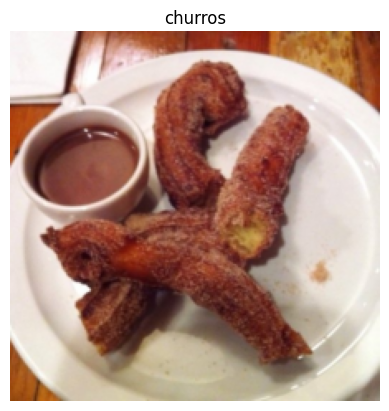

In [8]:
plot_image(train_data[0][0] , classes[train_data[0][1]])

# Creating Model

* starting with TinyVGG

In [9]:
class TinyVGG(nn.Module):
    def __init__(self , input_layer: int, hidden_layer:int, output_layer:int, dropout_rate: int = 0.25)->None:
        """
        A basic TinyVGG model to perform benchmark test for the model
        """
        super(TinyVGG, self).__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_layer, out_channels=hidden_layer, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(dropout_rate)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_layer, hidden_layer, 3, 1,1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),

            nn.Conv2d(hidden_layer, hidden_layer, 3, 1, 1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_layer*56*56 , output_layer)
        )
    
    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))

create a model instance

In [10]:
model_0 = TinyVGG(3 , 100 , len(classes)).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [11]:
image, label = train_data[0]
# Add batch dimension
image = image.unsqueeze(0)
model_0(image.to(device))

tensor([[-0.1910,  0.2511,  0.7834,  0.5205,  0.0381,  0.4944, -0.1941,  0.5058,
         -0.5003,  0.3445,  0.3377,  1.2402,  0.2233, -1.4655,  0.8364,  0.0958,
         -0.4298, -0.3881,  1.1669,  0.6973,  0.8964, -0.1463, -0.2647,  0.5834,
          0.1768,  0.5096,  0.7379,  0.7639,  2.0258,  0.8721, -0.6063, -0.2663,
         -1.4888, -0.2481, -0.0292,  0.9454,  0.0596, -0.0525,  0.2852,  0.0355,
         -0.0777, -0.1616,  0.2287,  0.5006,  0.0921, -0.9429,  0.0076, -1.2368,
          0.9623, -1.1238, -0.6315,  0.2154,  0.0468,  0.7022,  0.5251,  1.1415,
         -0.4916,  0.6944,  0.6528,  0.4641, -0.5354,  0.7305, -0.5133, -1.1473,
         -0.0146, -0.4322, -0.4698, -0.4246, -0.9059,  0.5609, -0.0402, -0.9576,
          0.5383, -0.1638, -0.2478,  0.1456, -1.0092,  0.3739,  0.7191, -0.1010,
          0.4764, -0.0990, -0.8951,  0.4374, -0.7097,  0.0996,  0.8748,  0.5266,
          0.7483, -0.1127,  0.3275,  0.6083, -0.7608, -0.0624,  0.3385,  0.8494,
          0.4910, -0.3592, -

This means that the model is successfully taking image values in the batchified form, so now we need to batchify it in the dataloaded

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(train_dataloader)
print(test_dataloader)

In [13]:
# Reduce dataset size for faster experimentation
from torch.utils.data import Subset

SMALL_TRAIN_SIZE = 1000  # You can adjust this number
SMALL_TEST_SIZE = 500

small_train_data = Subset(train_data, range(SMALL_TRAIN_SIZE))
small_test_data = Subset(test_data, range(SMALL_TEST_SIZE))

small_train_dataloader = DataLoader(
    dataset=small_train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Use 0 for Windows for stability
)

small_test_dataloader = DataLoader(
    dataset=small_test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Reduced train set size: {len(small_train_data)}")
print(f"Reduced test set size: {len(small_test_data)}")

Reduced train set size: 1000
Reduced test set size: 500


In [14]:
image, label = next(iter(train_dataloader))
print(f"Shape of Image:{image.shape} -> [Batches, color channels, height, weight]")

Shape of Image:torch.Size([32, 3, 224, 224]) -> [Batches, color channels, height, weight]


In [15]:
from torchinfo import summary

summary(model_0 , 
        input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 101]                 --
├─Sequential: 1-1                        [32, 100, 112, 112]       --
│    └─Conv2d: 2-1                       [32, 100, 224, 224]       2,800
│    └─BatchNorm2d: 2-2                  [32, 100, 224, 224]       200
│    └─ReLU: 2-3                         [32, 100, 224, 224]       --
│    └─Conv2d: 2-4                       [32, 100, 224, 224]       90,100
│    └─BatchNorm2d: 2-5                  [32, 100, 224, 224]       200
│    └─ReLU: 2-6                         [32, 100, 224, 224]       --
│    └─MaxPool2d: 2-7                    [32, 100, 112, 112]       --
│    └─Dropout2d: 2-8                    [32, 100, 112, 112]       --
├─Sequential: 1-2                        [32, 100, 56, 56]         --
│    └─Conv2d: 2-9                       [32, 100, 112, 112]       90,100
│    └─BatchNorm2d: 2-10                 [32, 100, 112, 112]       200
│

# performing training and testing on the model

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min",
                                                       patience=5,
                                                       factor=0.1)

In [ ]:
from helper.Process import run_train_test

result = run_train_test(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=torch.device(device),
    epochs=3
)

d:\FoodNet\mlvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File test


  0%|          | 0/3 [00:00<?, ?it/s]

Starting....

processing train batch:0

processing train batch:1

processing train batch:2

processing train batch:3

processing train batch:4

processing train batch:5

processing train batch:6

processing train batch:7

processing train batch:8

processing train batch:9

processing train batch:10

processing train batch:11

processing train batch:12

processing train batch:13

processing train batch:14

processing train batch:15

processing train batch:16

processing train batch:17

processing train batch:18

processing train batch:19

processing train batch:20

processing train batch:21

processing train batch:22

processing train batch:23

processing train batch:24

processing train batch:25

processing train batch:26

processing train batch:27

processing train batch:28

processing train batch:29

processing train batch:30

processing train batch:31

processing train batch:32

processing train batch:33

processing train batch:34

processing train batch:35

processing train batch:3